In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import rv_continuous
from scipy.stats import rel_breitwigner
import torch #Pytorch used to build and train ML models 
import flowtorch.bijectors as bij #contains different bijectors or transformation layers to build complex distributions
import flowtorch.distributions as dist #provides a way to define Normalizing Flows as a combination of a base distribtion and a set of transformations 
torch.cuda.is_available() #checking if a GPU is available for computations 

False

# Setup

## Background: exponential falling distribution, Signal: Breit-Wigner at certain mass

In [19]:
n_bkg = 400000
n_sig = 20
bkg = np.random.exponential(scale=100.0,size=n_bkg)
sig = rel_breitwigner.rvs(450, size=n_sig)

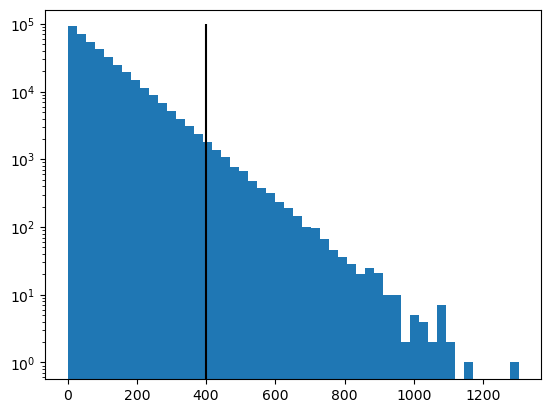

In [20]:
plt.hist([bkg,sig], bins=50, stacked=True)
plt.yscale('log')
plt.vlines(400.0, 0.0, 10**5, color='black', zorder=100) #mass threshold or cut 
plt.show()

#### Adding b-tagging information (a form of event classification)

In [21]:
bkg_btag = np.random.uniform(low=0.0, high=1.0, size=n_bkg) #events in the bkg probably coming from a b-quark 
sig_btag = s = np.random.normal(0.85, 0.05, n_sig) #events in the signal probably coming from a b-quark

#### Creating 2x2 grid of histograms splitting the events on 4 categories (based on energy and b-tagging)

(array([[917., 754., 626., 493., 401., 404., 290., 257., 202., 189., 146.,
         120., 111.,  90.,  82.,  48.,  54.,  60.,  41.,  27.,  29.,  14.,
          25.,  10.,   8.,  14.,  16.,  12.,   5.,   6.,   5.,   0.,   2.,
           2.,   3.,   0.,   1.,   5.,   1.,   2.,   0.,   0.,   1.,   0.,
           0.,   0.,   0.,   0.,   0.,   1.],
        [917., 754., 626., 493., 401., 404., 290., 257., 202., 189., 146.,
         120., 111.,  90.,  82.,  48.,  54.,  60.,  41.,  27.,  29.,  14.,
          25.,  10.,   8.,  14.,  16.,  12.,   5.,   6.,   5.,   0.,   2.,
           2.,   3.,   0.,   1.,   5.,   1.,   2.,   0.,   0.,   1.,   0.,
           0.,   0.,   0.,   0.,   0.,   1.]]),
 array([ 400.00991448,  418.05972657,  436.10953865,  454.15935074,
         472.20916283,  490.25897491,  508.308787  ,  526.35859909,
         544.40841117,  562.45822326,  580.50803535,  598.55784743,
         616.60765952,  634.65747161,  652.70728369,  670.75709578,
         688.80690787,  706.856719

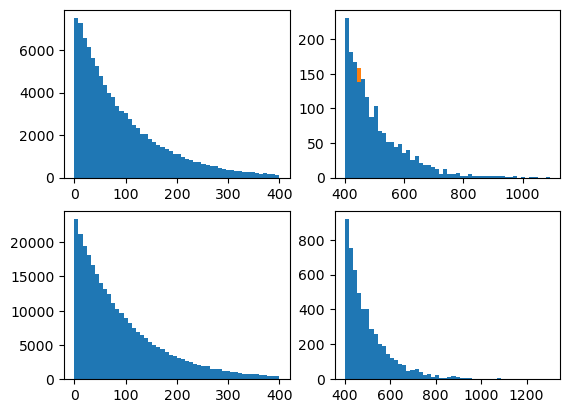

In [22]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist([bkg[(bkg_btag > 0.75) & (bkg < 400)], sig[(sig_btag > 0.75) & (sig < 400)]], bins=50, stacked=True)
axs[0, 1].hist([bkg[(bkg_btag > 0.75) & (bkg > 400)], sig[(sig_btag > 0.75) & (sig > 400)]], bins=50, stacked=True)
axs[1, 0].hist([bkg[(bkg_btag < 0.75) & (bkg < 400)], sig[(sig_btag < 0.75) & (sig < 400)]], bins=50, stacked=True)
axs[1, 1].hist([bkg[(bkg_btag < 0.75) & (bkg > 400)], sig[(sig_btag < 0.75) & (sig > 400)]], bins=50, stacked=True)
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()

#### Combining energy and b-tagging score for both bkg and signal 

In [23]:
bkg_coord = np.column_stack((bkg, bkg_btag))
sig_coord = np.column_stack((sig, sig_btag))

# Normalizing Flow Model

## Setup simple normalizing flow with arbitrary inputs & outputs just to test

In [11]:
# Define base and target distributions (needs to be replaced by above example)
base = torch.distributions.Independent(torch.distributions.Normal(torch.zeros(2), torch.ones(2)), 1) #base or prior distribution that the Normalizing Flow will transform 
target = torch.distributions.Independent(torch.distributions.Normal(torch.zeros(2)+5, torch.ones(2)*0.5),1) #target distribution which the Normalizing Flow should learn to approximate 

#### Setting up the normalizing flow and training loop

In [12]:
# Lazily instantiated flow
bijectors = bij.AffineAutoregressive() #defines an autoregressive transformation

# Instantiate transformed distribution and parameters
flow = dist.Flow(base, bijectors) #combines the base distribution with the bijectors to create a normalizing flow

# Training loop
opt = torch.optim.Adam(flow.parameters(), lr=5e-3) 
#optimizer that links the learning rate to the parameters of the flow/training model
#allowing the model's weights to be updated during training

for idx in range(3001): #at each of the training steps the following is done 
    opt.zero_grad()

    # Minimize KL(p || q)
    y = target.sample((1000,)) #sample points from target distribution

    loss = -flow.log_prob(y).mean() 
    #compute the loss function, which is the negative log probability of the sampled points under the flow model
    #meaning that the model is trying to incrase the probability of correctly genearting samples that match the target distribution
    #i.e. minimize the loss between target and trained distributions 

    if idx % 500 == 0:
        print('epoch', idx, 'loss', loss)

    loss.backward() #compute gradients of the loss function wrt model parameters 
    #gradient tells you how much the loss function will change if you adjust a particular parameter 
    opt.step() #updates the model parameters by adjusting them in the directon that reduces the loss function  
    

epoch 0 loss tensor(60.0706, grad_fn=<NegBackward0>)
epoch 500 loss tensor(3.7913, grad_fn=<NegBackward0>)
epoch 1000 loss tensor(3.3065, grad_fn=<NegBackward0>)
epoch 1500 loss tensor(3.0656, grad_fn=<NegBackward0>)
epoch 2000 loss tensor(2.7360, grad_fn=<NegBackward0>)
epoch 2500 loss tensor(2.0415, grad_fn=<NegBackward0>)
epoch 3000 loss tensor(1.4987, grad_fn=<NegBackward0>)


In [13]:
#Sampling same number of points from base (prior), target and trained distributions
prior = base.sample((1000,)).to('cpu').numpy()
posterior = target.sample((1000,)).to('cpu').numpy()
trained = flow.sample((1000,)).to('cpu').numpy()

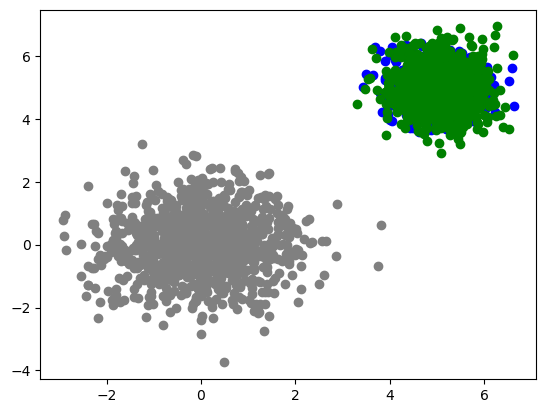

In [14]:
#Plots the sampled points into 2D space 
plt.scatter(prior[:,0],prior[:,1], color='gray')
plt.scatter(posterior[:,0],posterior[:,1], color='blue')
plt.scatter(trained[:,0],trained[:,1], color='green')
plt.show()

#Goal: the trained (green) distribution to match the target (blue) distribution after training,
#which would indicate that the flow succesfully transformed the base distribution into the target distribution

## Apply normalizing flow to 'real' dataset

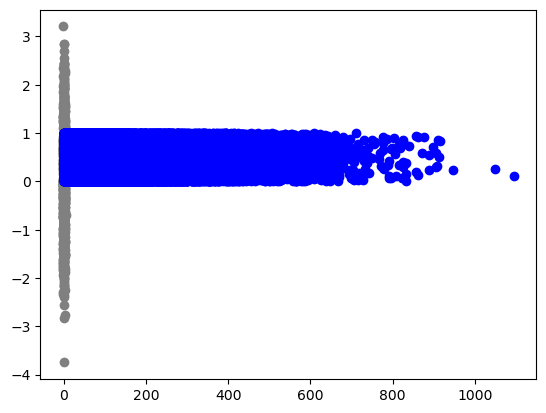

In [15]:
#visualizing base/prior and bkg data = target distribution to understand the base distribution before applying the flow model 
plt.scatter(prior[:,0],prior[:,1], color='gray')
plt.scatter(bkg_coord[:100000, 0],bkg_coord[:100000, 1], color='blue')
plt.show()

In [16]:
# Lazily instantiated flow
bijectors = bij.AffineAutoregressive() #initializes a neural network-based transformation
# Instantiate transformed distribution and parameters
flow = dist.Flow(base, bijectors) #define a parameterized distribution that transforms samples from the base distribution into the target distribution (in this case, the background data)

bkg_coord = bkg_coord.astype('float32') #bkg coordinates converted to float32 for compatibility with python  
y = torch.from_numpy(bkg_coord[:100000]) #create the training tensor: a PyTorch tensor with the first 100000 bkg samples to then train the flow model 
print(y.dtype)

# Training loop
opt = torch.optim.Adam(flow.parameters(), lr=5e-4) 
#optimizer that links the learning rate to the parameters of the flow/training model
#allowing the model's weights to be updated during training

last_loss = np.inf
patience = 0
for idx in range(4001): #for each training step the following is computed
    opt.zero_grad()

    # Minimize KL(p || q)
    loss = -flow.log_prob(y).mean()

    if idx % 1 == 0:
        print('epoch', idx, 'loss', loss)

    loss.backward()

    #patience mechanism keeps track of how many epochs have passed without improvement in loss. 
    #If the loss does not improve for 5 consecutive epochs, the training stops early to prevent overfitting.
    
    if loss > last_loss:
        patience += 1
    if patience >=5:
        break
    last_loss = loss
    
    opt.step()

    #Each time loss.backward() and opt.step() are executed, 
    #the parameters of the flow\trained model are adjusted to minimize the loss 

torch.float32
epoch 0 loss tensor(9177.0283, grad_fn=<NegBackward0>)
epoch 1 loss tensor(7318.7061, grad_fn=<NegBackward0>)
epoch 2 loss tensor(5841.8677, grad_fn=<NegBackward0>)
epoch 3 loss tensor(4668.5811, grad_fn=<NegBackward0>)
epoch 4 loss tensor(3752.5728, grad_fn=<NegBackward0>)
epoch 5 loss tensor(3033.4880, grad_fn=<NegBackward0>)
epoch 6 loss tensor(2469.7793, grad_fn=<NegBackward0>)
epoch 7 loss tensor(2025.3029, grad_fn=<NegBackward0>)
epoch 8 loss tensor(1670.7141, grad_fn=<NegBackward0>)
epoch 9 loss tensor(1386.3158, grad_fn=<NegBackward0>)
epoch 10 loss tensor(1156.7184, grad_fn=<NegBackward0>)
epoch 11 loss tensor(970.8544, grad_fn=<NegBackward0>)
epoch 12 loss tensor(820.1236, grad_fn=<NegBackward0>)
epoch 13 loss tensor(697.3195, grad_fn=<NegBackward0>)
epoch 14 loss tensor(596.5879, grad_fn=<NegBackward0>)
epoch 15 loss tensor(513.5084, grad_fn=<NegBackward0>)
epoch 16 loss tensor(444.6228, grad_fn=<NegBackward0>)
epoch 17 loss tensor(387.1919, grad_fn=<NegBackwar

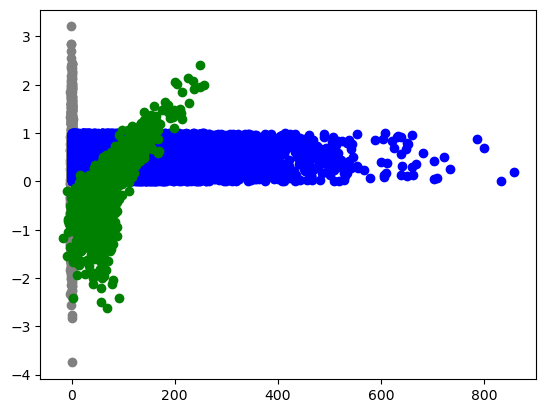

In [17]:
trained = flow.sample((1000,)).to('cpu').numpy() #flow model applies its transformation (defined by the bijectors) to samples from the base distribution 
#Note: As the parameters change during training, the transformation represented by flow also changes. 
#This means that after each training iteration, the way the flow generates samples from the base distribution changes.
#Here you're generating new samples based on the current state of the flow model (which has been updated during training).

plt.scatter(prior[:,0],prior[:,1], color='gray')
plt.scatter(bkg_coord[:10000, 0],bkg_coord[:10000, 1], color='blue')
plt.scatter(trained[:,0],trained[:,1], color='green')
plt.show()

In [ ]:
#using nflows model from chat gpt 
'''
import torch
from nflows import distributions, flows

# Define your base and target distributions
base_distribution = distributions.StandardNormal(shape=(2,))
# Define your flow (e.g., using an affine transformation)
flow = flows.Flow(base_distribution, transforms=... )

# Define optimizer
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    # Sample from your target distribution and compute the loss
    loss = ...  # Define your loss based on your application
    loss.backward()
    optimizer.step()
'''
